<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependenices" data-toc-modified-id="Dependenices-1">Dependenices</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Load-txi" data-toc-modified-id="Load-txi-5">Load txi</a></span></li><li><span><a href="#DEG-in-all-samples" data-toc-modified-id="DEG-in-all-samples-6">DEG in all samples</a></span></li></ul></div>

# Dependenices

In [1]:
library(DESeq2)
library(tximport)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.0.5”
Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, un

# Functions

# Paths

In [2]:
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Manifests/"
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Data_1/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Plots/"

In [3]:
h4hpath <- "/Users/anabbi/Desktop/H4H/"

In [4]:
gitpath <- "/Users/anabbi/git/iMATRIX-Atezo_Biomarker/data/"

# Main

In [5]:
metadata <- read.csv(file.path(datapath,"IND_metadata_IHC_trb_tmb.csv"),header = T, 
                     stringsAsFactors = F, check.names = F)

In [6]:
table(metadata$disease_group)


     EWS Lymphoma      NBL       OS   Others      RMS       RT     SARC 
       6       11        9        8        8        8        4        6 
   WILMS 
       6 

In [7]:
metadata$response <- NA
metadata$response[metadata$AVALC == "PD"] <- "No"
metadata$response[metadata$AVALC == "SD"] <- "Yes"
metadata$response[metadata$AVALC == "PR"] <- "Yes"

In [8]:
# only those with resposne data
metadata <- metadata[!is.na(metadata$response),]

In [9]:
dim(metadata)

[1] 60 74

In [10]:
table(metadata$response)


 No Yes 
 49  11 

In [20]:
files <- list.files(paste0(h4hpath, "INDICATE/src"),pattern = "genes", full.names = T)

In [21]:
names(files) <- gsub(".*go29664_ngs_rna_targrna_rnaaccess_", "", files)
names(files) <- gsub(".genes.results", "", names(files))
names(files) <- gsub("_20171125", "", names(files))
names(files) <- gsub("_20180223", "", names(files))
names(files) <- toupper( names(files))

In [22]:
files <- files[names(files) %in% metadata$sample_id]

In [23]:
length(metadata$sample_id)

[1] 60

Get a list of genes that are nonzero in at least half of samples

In [24]:
txi <- tximport(files[ names(files) %in% metadata$sample_id ], type = "rsem", txIn = FALSE, txOut = FALSE)
txi$length[txi$length == 0] <- 1

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 


In [25]:
save(txi, file = paste0(datapath, "DEG/txi.RData"))

# Load txi

In [26]:
load(file = paste0(datapath, "DEG/txi.RData"))

In [27]:
dds <- DESeqDataSetFromTximport(txi, colData = metadata, 
                                design = ~ EA.Sequencing.Batch + disease_group + sample_origin + response)
dds$response <- relevel(dds$response, ref = "No")

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using counts and average transcript lengths from tximport



Remove low expressed genes

In [28]:
dds <- estimateSizeFactors(dds)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size



In [29]:
mymat <- assay(dds)

In [30]:
dim(mymat)

[1] 60155    60

Keep genes that have more than 10 count in more than 10% (n = 6) samples

In [31]:
sumgenes <- rowSums(mymat >= 10)
keep <- sumgenes[ sumgenes > 6]

In [32]:
mymat_s <- mymat[names(keep),]

In [33]:
dim(mymat)

[1] 60155    60

In [34]:
dim(mymat_s)

[1] 22266    60

Remove log10(var) < 0

In [35]:
mock <- dds[which(rownames(dds) %in% rownames(mymat_s)), ]

In [36]:
dim(mock)

[1] 22266    60

In [37]:
mock <- estimateSizeFactors(mock)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size



In [38]:
normmat <- assay(mock,normalize=T)

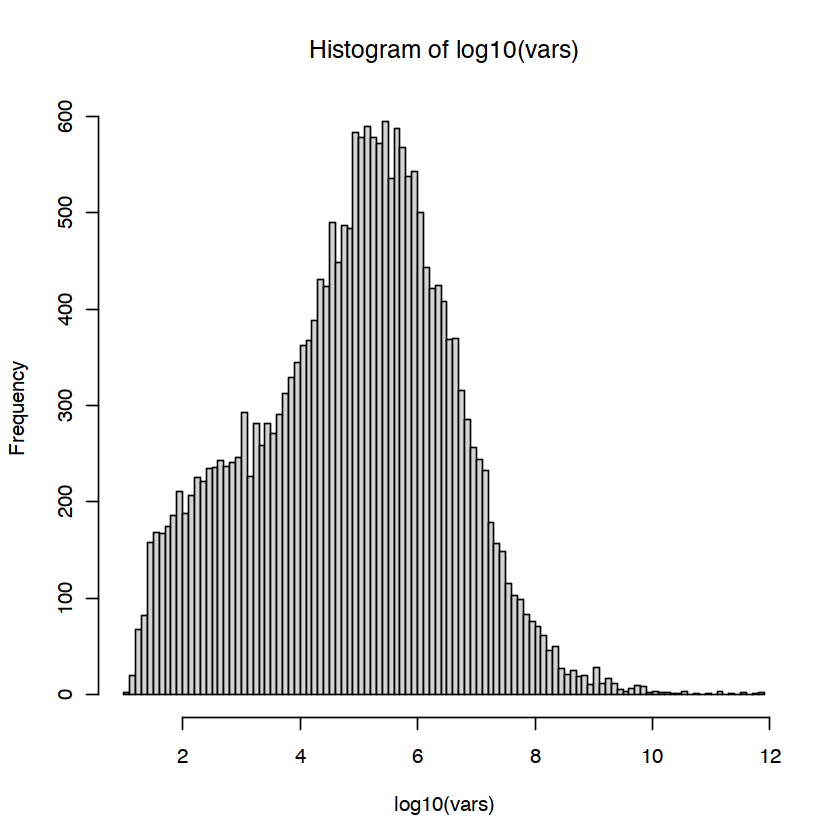

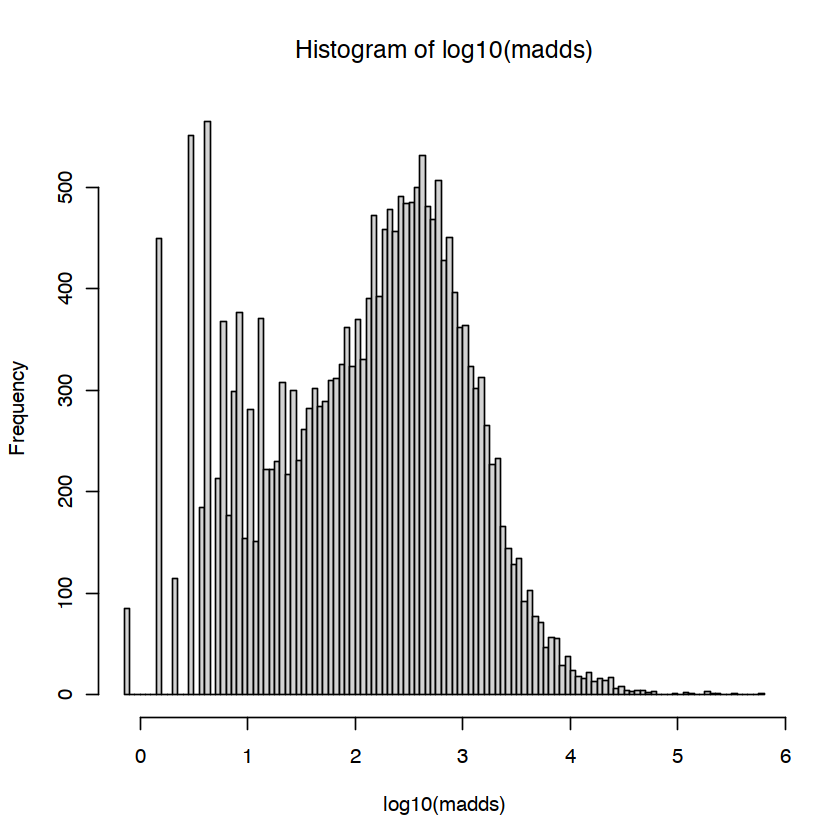

In [39]:
#var
vars <- rowVars(normmat)
names(vars) <- row.names(normmat)
#mad
madds <- rowMads(normmat)
names(madds) <- row.names(normmat)
#plot hist
hist(log10(vars),100)
hist(log10(madds),100)
# which genes with log10(var) and log10(mad) < 0
VarMad <- c(names(which(log10(vars) < 0)),names(which(log10(madds) <0)))

In [40]:
dds <- dds[which(rownames(dds) %in% rownames(mymat_s)), ]

In [41]:
dim(dds)

[1] 22266    60

In [44]:
#remove genes with log10(var) and log10(mad) < 0
dds <- dds[ -which(rownames(dds) %in% VarMad), ]

In [45]:
dim(dds)

[1] 21316    60

In [46]:
#remove version
names(dds) <- gsub("[.].*", "", names(dds))

# DEG in all samples

add hgnc symbols using mart

In [48]:
hg38 <- biomaRt::useMart(biomart="ENSEMBL_MART_ENSEMBL", host="useast.ensembl.org", 
                path="/biomart/martservice", dataset="hsapiens_gene_ensembl")

In [49]:
ids <- names(dds)

In [51]:
ensembl_hgnc_biotype <- biomaRt::getBM(filters="ensembl_gene_id",
                              attributes=c("ensembl_gene_id", "hgnc_symbol", "entrezgene_id", "gene_biotype"), 
                              values= ids, mart=hg38)

In [52]:
proteincoding <- ensembl_hgnc_biotype[ ensembl_hgnc_biotype$gene_biotype == "protein_coding",]

In [53]:
# duplicated ensembl are mostly those with difference entrez
proteincoding <- proteincoding[!duplicated(proteincoding$ensembl_gene_id),]

In [54]:
dds_all <- DESeq(dds, parallel = TRUE)

using pre-existing normalization factors

estimating dispersions

gene-wise dispersion estimates: 2 workers

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates, fitting model and testing: 2 workers

R_zmq_msg_send errno: 4 strerror: Interrupted system call

R_zmq_msg_send errno: 4 strerror: Interrupted system call

  Note: levels of factors in the design contain characters other than
  let

Get results

In [55]:
res <- as.data.frame(results(dds_all, contrast= c("response", "Yes", "No")))

Add gene names using biomart and using the gencode v21. 

In [56]:
genesgencodev21 <- read.csv(paste0(datapath, "exp_mat/ensembl_HGNC_gencode.v21.annotation.gtf.csv"))

In [57]:
genesgencodev21$ensembl <- gsub("[.].*", "", genesgencodev21$gene_id)

In [58]:
head(genesgencodev21)

,gene_id,gene_name,ensembl
,<chr>,<chr>,<chr>
1,ENSG00000223972.5,DDX11L1,ENSG00000223972
2,ENSG00000227232.5,WASH7P,ENSG00000227232
3,ENSG00000278267.1,MIR6859-2,ENSG00000278267
4,ENSG00000243485.3,MIR1302-10,ENSG00000243485
5,ENSG00000274890.1,MIR1302-11,ENSG00000274890
6,ENSG00000237613.2,FAM138A,ENSG00000237613


In [59]:
res$Gene_gencode <-  genesgencodev21$gene_name[ match( rownames(res), genesgencodev21$ensembl)]

In [60]:
res$Gene_mart <-  proteincoding$hgnc_symbol[ match( rownames(res), proteincoding$ensembl_gene_id)]

In [61]:
res_all <- res

In [62]:
head(res_all)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene_gencode,Gene_mart
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000000003,927.36451,-0.16995178,0.3222090,-0.5274581,0.59787547,0.9872860,TSPAN6,TSPAN6
ENSG00000000005,31.24901,-0.25489503,0.8887613,-0.2867981,0.77426694,0.9962345,TNMD,TNMD
ENSG00000000419,3565.47595,0.07491173,0.1889612,0.3964396,0.69178073,0.9957530,DPM1,DPM1
ENSG00000000457,631.86918,0.23887003,0.1368761,1.7451552,0.08095786,0.8417688,SCYL3,SCYL3
ENSG00000000460,1633.68728,-0.40124676,0.2707462,-1.4820032,0.13833945,0.8923813,C1orf112,C1orf112
ENSG00000000938,415.87614,0.53971820,0.5573822,0.9683090,0.33289006,0.9653727,FGR,FGR


In [63]:
save(res_all, file = paste0(gitpath, "DESeq2_results_allsamples.RData"))